In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('science')

import numpy as np
import sys; sys.path.insert(0, "../"); from utils import *

In [12]:
eq_name = "Burgers' PDE: 3000 labels, $\lambda=10^{-3}$"
feature_names = ["u", "u_{x}", "u_{xx}", "u_{xxx}"]
feature_names = ['$'+e+'$' for e in feature_names]
feature_importance = [0.6721, 0.7903, 0.7139, 0.3486]
feature_importance = npar(feature_importance)

In [15]:
def plot_feature_importance_neural_net(feature_importances, feature_names, eq_name=eq_name, save_path=None):
    threshold = 1/len(feature_names)
    
    # split it up
    above_threshold = np.maximum(feature_importance - threshold, 0)
    below_threshold = np.minimum(feature_importance, threshold)

    # and plot it
    fig, ax = plt.subplots()
    ax.bar(feature_names, below_threshold, 0.35, color="g")
    ax.bar(feature_names, above_threshold, 0.35, color="r", bottom=below_threshold)
    
    # horizontal line indicating the threshold
    ax.plot([-0.175, len(feature_names)*0.8], [threshold, threshold], "k--")
    plt.title(eq_name)
    plt.xlabel("Partial derivative candidates\n$[u_t = -0.970158uu_{x}+0.003090u_{xx}]$")
    plt.ylabel("Feature importance")
    
    if save_path is not None: fig.savefig(save_path, dpi=300)

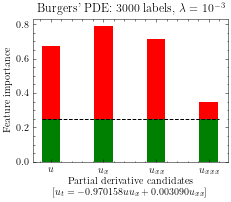

In [16]:
# save_path = "./hyperparameter_study/lambda/1e-5.png"
save_path = None
with plt.style.context(['science']):
    plot_feature_importance_neural_net(feature_importance, feature_names, eq_name, save_path=save_path)

In [1]:
# !rm './tmp.jpg'

In [5]:
# No selector network (Not the same as setting lambda_1 to 0.0) 
# PDE derived using STRidge
# u_t = (0.002543 +0.000000i)u_xx
#     + (-0.832252 +0.000000i)uf*u_x

# 1e-1
# tensor([0.2735, 0.1883, 0.2060, 0.2133])
# u_t = (0.002695 +0.000000i)u_xx
#     + (-0.924525 +0.000000i)uf*u_x

# 1e-3
# tensor([0.8153, 0.8142, 0.4398, 0.1562])
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x

# 1e-5
# tensor([0.6721, 0.7903, 0.7139, 0.3486])
# u_t = (0.002594 +0.000000i)u_xx
#     + (-0.885143 +0.000000i)uf*u_x

In [6]:
# Goals!!!
# 3000 | eq found by STR | eq after PINN fine-tuning + mean error
# 1000 | eq found by STR | eq after PINN fine-tuning + mean error
# 500 | eq found by STR | eq after PINN fine-tuning + mean error

# 3000
# eq found by STR 
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x
# eq after PINN fine-tuning + mean error
# (-0.9994307160377502, 0.0031862353649783444)
# (0.07773227423228249, )

# 1000
# eq found by STR
# u_t = (0.002631 +0.000000i)u_xx
#     + (-0.860374 +0.000000i)uf*u_x
# eq after PINN fine-tuning + mean error
# (-0.9891335368156433, 0.0031485233921557665)
# (1.0864333669569826, 0.0002129514786863851)

# 500
# eq found by STR (failed)
# u_t = (-0.072116 +0.000000i)uf*u_x